# Import module

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import yfinance as yf

## Load data

In [2]:
# Load the data
df = yf.download("MSFT", start="2000-01-01", end="2023-12-31")
df.drop(["Adj Close", "Volume"], axis=1, inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df

,Open,High,Low,Close
Date,,,,
2000-01-03,58.687500,59.312500,56.000000,58.281250
2000-01-04,56.781250,58.562500,56.125000,56.312500
2000-01-05,55.562500,58.187500,54.687500,56.906250
2000-01-06,56.093750,56.937500,54.187500,55.000000
2000-01-07,54.312500,56.125000,53.656250,55.718750
...,...,...,...,...
2023-12-22,373.679993,375.179993,372.709991,374.579987
2023-12-26,375.000000,376.940002,373.500000,374.660004
2023-12-27,373.690002,375.059998,372.809998,374.070007


In [4]:
len(df)

6037

In [5]:
# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 20
x, y = create_sequences(df.values, seq_length)

# Split into train and test
train_size = int(len(y) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

## Create input


In Keras, the input shape for an LSTM (Long Short-Term Memory) layer depends on the format of your data.
The LSTM layer expects input in the form of a 3D tensor with shape (batch_size, timesteps, input_dim).

+Batch_size: The number of samples in each batch. This dimension is typically left unspecified or set to None in the input shape, allowing for variable batch sizes during training and inference.

+Timesteps: The number of time steps or sequences in your input data. For example, if you have a time series of length 100, and you want to consider 20 previous time steps as input for each sample, then timesteps would be 20.

+Input_dim: The number of features or dimensions in each time step of your input data.

In [ ]:
#Sequence Creation Function for Time Series Data
def create_sequences(data: pd.DataFrame, seq_length: int):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data.iloc[i:i+seq_length, :])
        y.append(data.iloc[i+seq_length, 3])
    return np.array(X), np.array(y)

seq_length = 20
num_features = 4
X,Y = create_sequences(df,seq_length)

In [ ]:
print(X.shape)
print(Y.shape)

(10816, 20, 4)
(10816,)


## Data preparation


Since in this model, we use time series so we can not suffle data. We dive whole data into 2 part: train set and test set without suffle.

In [ ]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
x_train, x_test = X[0:train_size,:], X[train_size:,:]
y_train, y_test = Y[0:train_size], Y[train_size:]

In [ ]:
scalerX = MinMaxScaler(feature_range=(0,1))
scalerY = MinMaxScaler(feature_range = (0,1))

x_train = scalerX.fit_transform(x_train.reshape(-1,num_features * seq_length))
x_test = scalerX.transform(x_test.reshape(-1,num_features * seq_length))
y_train = scalerY.fit_transform(y_train.reshape(-1,1))
y_test = scalerY.transform(y_test.reshape(-1,1))


In [ ]:
x_train = x_train.reshape(-1,seq_length,num_features)
x_test = x_test.reshape(-1,seq_length, num_features)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(8668, 20, 4)
(8668, 1)


## Visualization

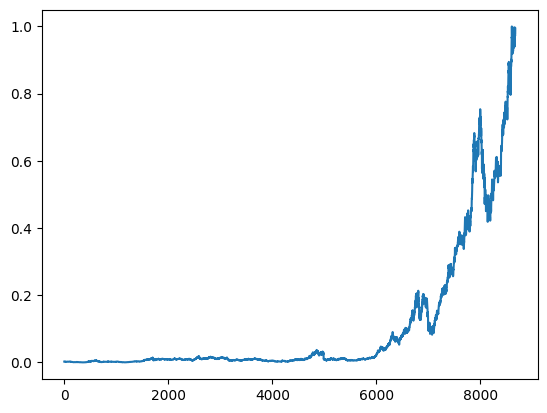

In [ ]:
plt.plot(y_train)
plt.show()

## Grid search

In [ ]:
def create_model(neurons, optimizer):
 # create model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(seq_length,4), activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [ ]:
optimizer = ['GDA','Nadam']
neurons = [100,500,1000,2000]
param_grid = dict(model__neurons=neurons, model__optimizer = optimizer)

model = KerasRegressor(model=create_model, epochs=10, batch_size=5, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)
best_params = grid.best_params_

In [ ]:
best_model = create_model(neurons=500, optimizer='Nadam')
best_model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)
y_pred = best_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


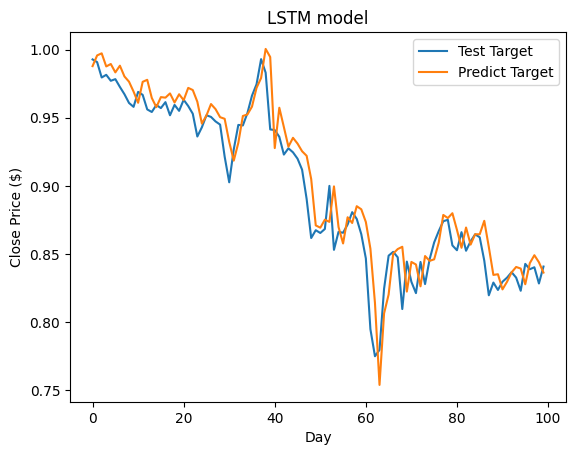

In [ ]:
plt.title("LSTM model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(y_test[:100], label = "Test Target")
plt.plot(y_pred[:100], label = "Predict Target")
plt.legend()
plt.show()

Actually in this case, when we run more complex model, we have more smooth model and the mean square error decrease but not significantly. All of these models convergence to an similar shape with a tiny difference about degree of smoothness. Running all of this grid search is time-consuming without a big improvement so we choose a not complex model to analyze and get insight from this family of models.

## Create model


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=500, input_shape=(seq_length, num_features)))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs= 10, batch_size=32, verbose=2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


271/271 - 5s - 17ms/step - loss: 3.3675e-04
Epoch 2/10
271/271 - 1s - 5ms/step - loss: 4.8094e-05
Epoch 3/10
271/271 - 3s - 9ms/step - loss: 6.2364e-05
Epoch 4/10
271/271 - 3s - 9ms/step - loss: 4.1791e-05
Epoch 5/10
271/271 - 1s - 5ms/step - loss: 3.6240e-05
Epoch 6/10
271/271 - 1s - 5ms/step - loss: 3.6802e-05
Epoch 7/10
271/271 - 3s - 9ms/step - loss: 3.5817e-05
Epoch 8/10
271/271 - 1s - 5ms/step - loss: 4.1683e-05
Epoch 9/10
271/271 - 1s - 5ms/step - loss: 4.3572e-05
Epoch 10/10
271/271 - 3s - 9ms/step - loss: 3.3045e-05


In [ ]:
x_train.shape

(8668, 20, 4)

In [ ]:
# make predictions
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
print(testPredict)
# invert predictions
trainPredict = scalerY.inverse_transform(trainPredict.reshape(-1,1))
trainY = scalerY.inverse_transform(y_train.reshape(-1,1))
testPredict = scalerY.inverse_transform(testPredict.reshape(-1,1))
testY = scalerY.inverse_transform(y_test.reshape(-1,1))
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[0.9902254 ]
 [0.98934036]
 [0.99105114]
 ...
 [5.3956003 ]
 [5.4181786 ]
 [5.3879843 ]]
Train Score: 0.15 RMSE
Test Score: 4.42 RMSE


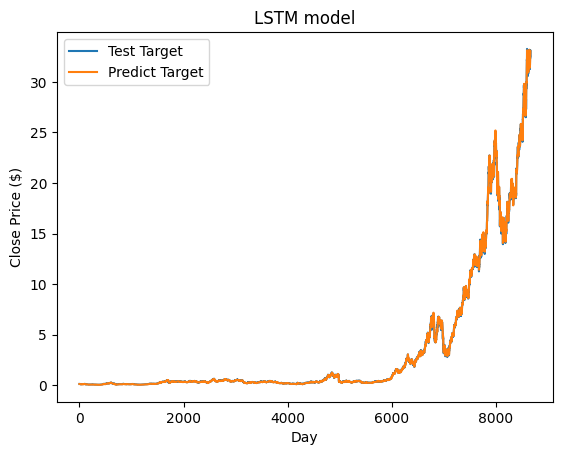

In [ ]:
plt.title("LSTM model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(trainY, label = "Test Target")
plt.plot(trainPredict, label = "Predict Target")
plt.legend()
plt.show()

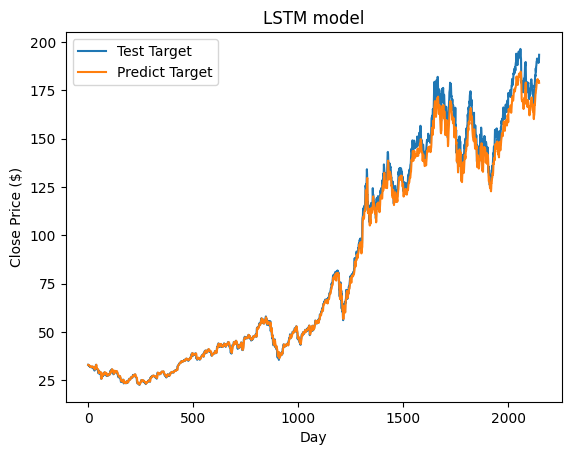

In [ ]:
plt.title("LSTM model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(testY, label = "Test Target")
plt.plot(testPredict, label = "Predict Target")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score
r2_test = r2_score(testY, testPredict)
r2_train = r2_score(trainY, trainPredict)
print("R-squared on train set:", r2_train)
print("R-squared on test set:", r2_test)

R-squared on train set: 0.9995074658982288
R-squared on test set: 0.9936412340074358


## Test for other stock without training


In [ ]:
df_test = pd.read_csv("/content/MSFT.csv")
df_test.reset_index(drop = True, inplace = True)
#Drop columns
df_test.drop(["Adj Close", "Volume","Date"], axis = 1, inplace = True)

In [ ]:
df_test

,Open,High,Low,Close
0,0.088542,0.101563,0.088542,0.097222
1,0.097222,0.102431,0.097222,0.100694
2,0.100694,0.103299,0.100694,0.102431
3,0.102431,0.103299,0.098958,0.099826
4,0.099826,0.100694,0.097222,0.098090
...,...,...,...,...
9078,295.369995,301.000000,292.730011,300.429993
9079,298.890015,300.140015,294.899994,299.160004
9080,299.799988,305.000000,298.769989,304.059998
9081,300.510010,303.230011,297.720001,299.489990


In [ ]:
otherX,otherY = create_sequences(df,seq_length)
print(otherX.shape)
print(otherY.shape)

(10816, 20, 4)
(10816,)


In [ ]:
otherx_test = scalerX.transform(otherX.reshape(-1,num_features * seq_length))
othery_test = scalerY.transform(otherY.reshape(-1,1))

In [ ]:
otherx_test = otherx_test.reshape(-1,seq_length, num_features)
print(otherx_test.shape)

(10816, 20, 4)


In [ ]:
otherPredict = model.predict(otherx_test)

338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


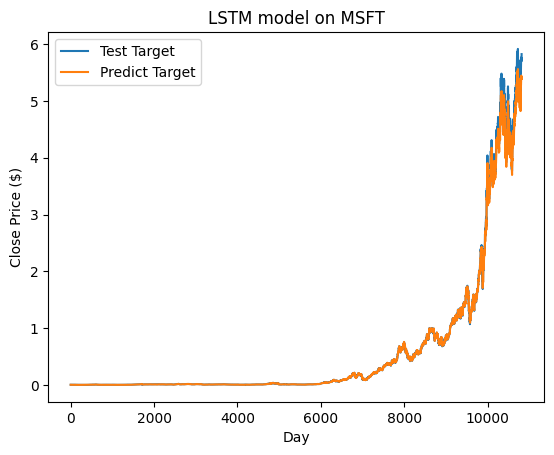

In [ ]:
plt.title("LSTM model on MSFT")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(othery_test, label = "Test Target")
plt.plot(otherPredict, label = "Predict Target")
plt.legend()
plt.show()

In [ ]:
other_r2_test = r2_score(othery_test, otherPredict)
print(other_r2_test)

0.9977288266514692


As we can see, without training phase, our model can predict other stock price of IBM which fluatuate differently as well as S&P500

## Using RNN model

In [ ]:
# create and fit the LSTM network
RNNmodel = Sequential()
RNNmodel.add(SimpleRNN(500, input_shape=(seq_length, num_features), activation = 'relu'))
RNNmodel.add(Dense(1))
RNNmodel.compile(loss='mean_squared_error', optimizer='adam')
RNNmodel.fit(x_train, y_train, epochs= 10, batch_size=32, verbose=2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


271/271 - 4s - 14ms/step - loss: 4.9557e-04
Epoch 2/10
271/271 - 1s - 3ms/step - loss: 3.1775e-05
Epoch 3/10
271/271 - 1s - 3ms/step - loss: 2.8057e-05
Epoch 4/10
271/271 - 1s - 5ms/step - loss: 3.0961e-05
Epoch 5/10
271/271 - 1s - 5ms/step - loss: 2.5367e-05
Epoch 6/10
271/271 - 1s - 5ms/step - loss: 2.8557e-05
Epoch 7/10
271/271 - 1s - 3ms/step - loss: 2.5009e-05
Epoch 8/10
271/271 - 1s - 4ms/step - loss: 3.5487e-05
Epoch 9/10
271/271 - 1s - 5ms/step - loss: 3.1806e-05
Epoch 10/10
271/271 - 1s - 4ms/step - loss: 2.2123e-05


In [ ]:
# make predictions
RNNtrainPredict = model.predict(x_train)
RNNtestPredict = model.predict(x_test)
print(testPredict)
# invert predictions
RNNtrainPredict = scalerY.inverse_transform(RNNtrainPredict.reshape(-1,1))
RNNtrainY = scalerY.inverse_transform(y_train.reshape(-1,1))
RNNtestPredict = scalerY.inverse_transform(RNNtestPredict.reshape(-1,1))
RNNtestY = scalerY.inverse_transform(y_test.reshape(-1,1))
# calculate root mean squared error
RNNtrainScore = np.sqrt(mean_squared_error(RNNtrainY, RNNtrainPredict))
print('Train Score: %.2f RMSE' % (RNNtrainScore))
RNNtestScore = np.sqrt(mean_squared_error(RNNtestY, RNNtestPredict))
print('Test Score: %.2f RMSE' % (RNNtestScore))

271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[ 32.925472]
 [ 32.89609 ]
 [ 32.95289 ]
 ...
 [179.18785 ]
 [179.93747 ]
 [178.935   ]]
Train Score: 0.15 RMSE
Test Score: 4.42 RMSE


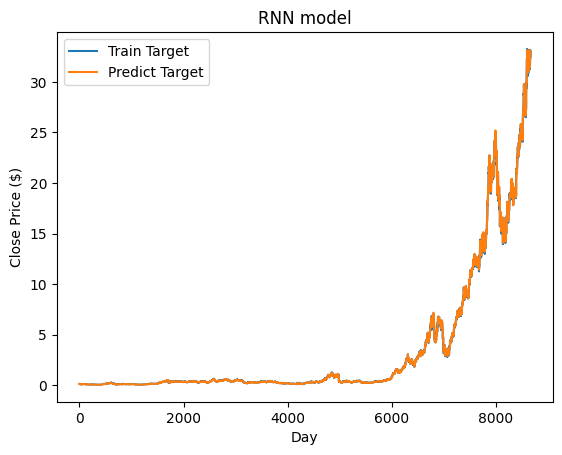

In [ ]:
plt.title("RNN model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(RNNtrainY, label = "Train Target")
plt.plot(RNNtrainPredict, label = "Predict Target")
plt.legend()
plt.show()

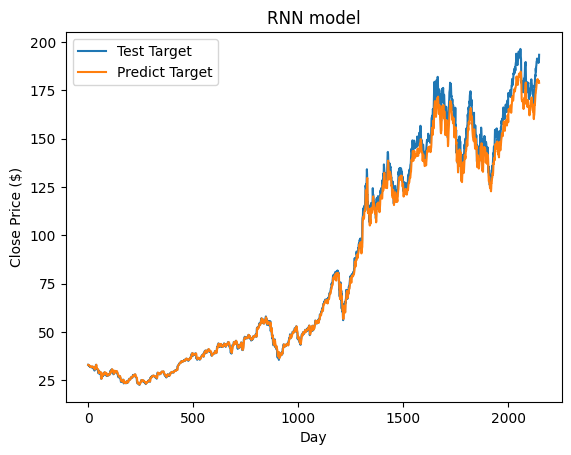

In [ ]:
plt.title("RNN model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(RNNtestY, label = "Test Target")
plt.plot(RNNtestPredict, label = "Predict Target")
plt.legend()
plt.show()


## Test with random data

###### For simplictit, we create an new model with feature of each timestep is close price of previous day

In [ ]:
df = pd.read_csv("/content/MSFT.csv",index_col="Date")
df = df['Close']
df.reset_index()
df = df.to_frame()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
scaledData = scaler.fit_transform(df)

In [ ]:
def create_sequences(data, seq_length):
    print(data)
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)
scaledX, scaledY = create_sequences(scaledData, 20)

[[2.02437349e-05]
 [3.03656023e-05]
 [3.54294513e-05]
 ...
 [8.86158182e-01]
 [8.72835309e-01]
 [8.86274817e-01]]


In [ ]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
x_train, x_test = scaledX[0:train_size,:], scaledX[train_size:,:]
y_train, y_test = scaledY[0:train_size], scaledY[train_size:]

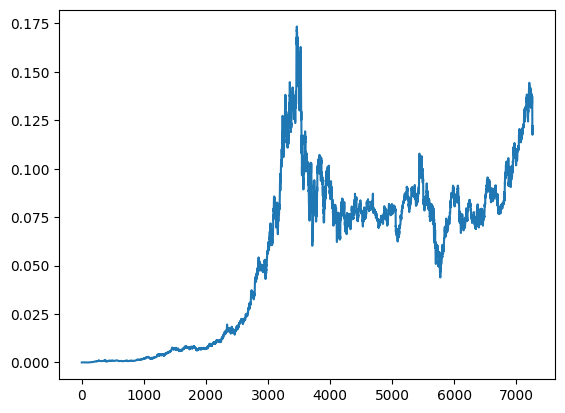

In [ ]:
plt.plot(y_train)
plt.show()

In [ ]:
seq_length = 20
x_train = np.reshape(x_train,(x_train.shape[0],seq_length,1))
x_test = np.reshape(x_test,(x_test.shape[0],seq_length,1))
print(len(x_test))

1797


In [ ]:
model = Sequential()
model.add(LSTM(500, input_shape=(seq_length,1), activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7266/7266 - 37s - 5ms/step - loss: 2.4373e-05
Epoch 2/10
7266/7266 - 39s - 5ms/step - loss: 8.0880e-06
Epoch 3/10
7266/7266 - 41s - 6ms/step - loss: 6.5037e-06
Epoch 4/10
7266/7266 - 41s - 6ms/step - loss: 6.8040e-06
Epoch 5/10
7266/7266 - 34s - 5ms/step - loss: 5.3656e-06
Epoch 6/10
7266/7266 - 40s - 6ms/step - loss: 5.0181e-06
Epoch 7/10
7266/7266 - 34s - 5ms/step - loss: 4.7420e-06
Epoch 8/10
7266/7266 - 33s - 5ms/step - loss: 4.5131e-06
Epoch 9/10
7266/7266 - 41s - 6ms/step - loss: 3.8002e-06
Epoch 10/10
7266/7266 - 41s - 6ms/step - loss: 3.6687e-06


In [ ]:

# make predictions
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
print(testPredict)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[0.1203448 ]
 [0.12215909]
 [0.12246251]
 ...
 [0.9034944 ]
 [0.94718355]
 [0.89391166]]
Train Score: 0.52 RMSE
Test Score: 7.11 RMSE


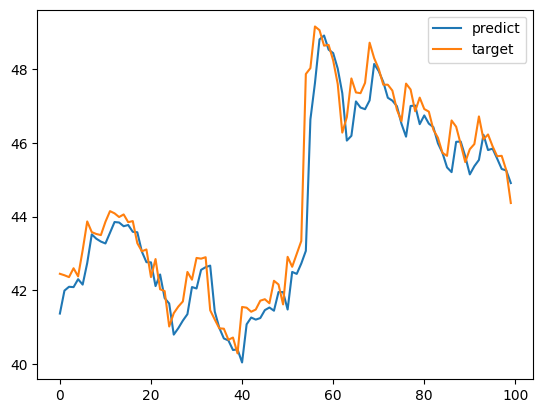

In [ ]:
plt.plot(testPredict[:100], label = "predict")
plt.plot(testY[:100], label = "target")
plt.legend()

From here we can also see that compare to four-feature model, there is not many difference

#### Create random data


In [ ]:
np.random.seed(100)
data_test = np.random.random((200,1))
data_test

array([[0.54340494],
       [0.27836939],
       [0.42451759],
       [0.84477613],
       [0.00471886],
       [0.12156912],
       [0.67074908],
       [0.82585276],
       [0.13670659],
       [0.57509333],
       [0.89132195],
       [0.20920212],
       [0.18532822],
       [0.10837689],
       [0.21969749],
       [0.97862378],
       [0.81168315],
       [0.17194101],
       [0.81622475],
       [0.27407375],
       [0.43170418],
       [0.94002982],
       [0.81764938],
       [0.33611195],
       [0.17541045],
       [0.37283205],
       [0.00568851],
       [0.25242635],
       [0.79566251],
       [0.01525497],
       [0.59884338],
       [0.60380454],
       [0.10514769],
       [0.38194344],
       [0.03647606],
       [0.89041156],
       [0.98092086],
       [0.05994199],
       [0.89054594],
       [0.5769015 ],
       [0.74247969],
       [0.63018394],
       [0.58184219],
       [0.02043913],
       [0.21002658],
       [0.54468488],
       [0.76911517],
       [0.250

In [ ]:
df_test = pd.DataFrame(data_test)

In [ ]:
def create_sequences(data: pd.DataFrame, seq_length: int):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data.iloc[i:i+seq_length, :])
        y.append(data.iloc[i+seq_length, 0])
    return np.array(X), np.array(y)
X_test, Y_test = create_sequences(df_test, 20)
X_test.shape

(180, 20, 1)

In [ ]:
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [ ]:
testPredict = scaler.inverse_transform(y_pred)
testY = scaler.inverse_transform(Y_test.reshape(-1,1))

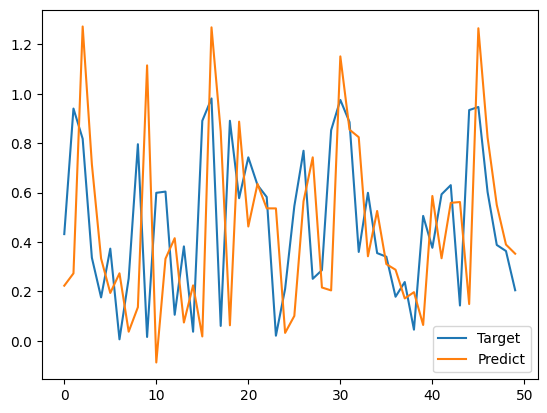

In [ ]:
plt.plot(Y_test[0:50], label = 'Target')
plt.plot(y_pred[0:50], label = 'Predict')
plt.legend()

###### Shift 1 day

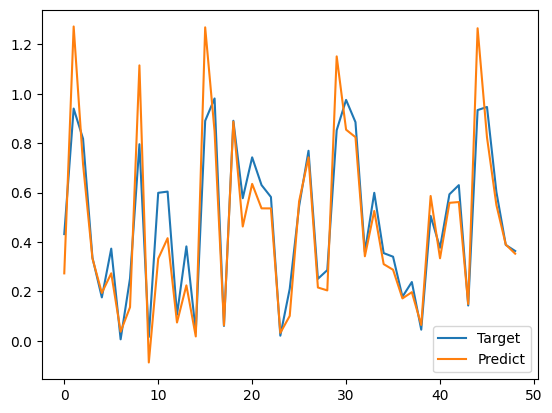

In [ ]:
plt.plot(Y_test[0:49], label = 'Target')
plt.plot(y_pred[1:50], label = 'Predict')
plt.legend()